# A Latent Space Model for Hypergraphs

* Let $G=(V,E)$ be a hypergraph, where $E$ is the collection of hyperedges.
* Let $H$ be the collection of admisible combinations of nodes, (e.g., if we only consider hyperedges of size less than 10). 
* $G$ is modeled as a collection of random variables ${X_h: h\in H}$.
* $X_h\sim Bernoulli(p_h)$.
* The mean $p_h$ depends on the features of nodes in $h$: $$p_h=\frac{e^{-\alpha|h|}\sum_k\prod_{i\in h}\theta_{ik}}{1+e^{-\alpha|h|}\sum_k\prod_{i\in h}\theta_{ik}},$$ where $\theta_i$: the latent feature vector for node $i$.
* Assume $X_h$'s are independent of each other given $\theta=(\theta_i)$.
* The distribution of $G$ is given by $$p(G|\theta)=\prod_{h\in H} p(x_h|\theta)$$.
* Take a Bayesian approach to estimate $\theta$ and sample $\theta$ from the posterior using MCMC.
    * Propose $\theta'$.
    * Draw $G'$ given $\theta'$.
        * Start from $G$.
        * Every step pick $h\in H$ at random.
        * Draw $X_e$ from $Poisson(\lambda_h(\theta'))$.
    * Move to $\theta'$ with probability $\rho$.

In [20]:
%matplotlib inline
import pylab as plt
import numpy as np
import scipy.sparse as ssp
import random
from collections import Counter
from scipy.stats import dirichlet, truncnorm
import sys
import pickle
import time
from string import lower
from itertools import combinations, izip, chain
from collections import Counter
from scipy.stats import pearsonr, norm, poisson
from scipy.misc import comb
import networkx as nx

In [2]:
class Stopwatch:
    start_time=None
    def go(self,msg=''):
        if msg:
            print msg,
        self.start_time=time.time()
        sys.stdout.flush()
    def stop(self,msg=''):
        if msg:
            print "{}: {} seconds".format(msg,time.time()-self.start_time)
        else:
            print "Elapsed time: {} seconds".format(time.time()-self.start_time)
        sys.stdout.flush()
    def check(self):
        return time.time()-self.start_time


def LoadDate(filename):
    tic=Stopwatch()
    print "Loading paper dates %s from disk..." % filename,
    tic.go()
    pkl_file = open(filename, 'rb')
    A=pickle.load(pkl_file)
    pkl_file.close()
    tic.stop()
    return A


def LoadData(filename):
    tic=Stopwatch()
    print "Loading file %s from disk..." % filename,
    tic.go()
    pkl_file = open(filename, 'rb')   
    (row,col) = pickle.load(pkl_file)        
    pkl_file.close()
    A=ssp.coo_matrix((np.ones(len(row),dtype=np.int8),(row,col)),shape=(19916562,col.max()+1),dtype=np.float)
    tic.stop()
    return A

### Initialization

* Read in the hypergraph of Medline

In [3]:
tic=Stopwatch()

tic.go('Loading citation data...')
citations=pickle.load(open('../hypergraph/citations.pkl'))
tic.stop()
# Load hypergraphs
thing=['Author','Chemical','Disease','Method']
G=[]
for i in range(1,4):
    G.append(LoadData('../hypergraph/'+lower(thing[i])+'.pkl'))
G=ssp.hstack(G).tocsr()

paper_dates=LoadDate('../hypergraph/date.pkl') # Load publicatioin dates

id2chemical=pickle.load(open('../hypergraph/Citation/id2chemical.pkl'))
id2disease=pickle.load(open('../hypergraph/Citation/id2disease.pkl'))
id2method=pickle.load(open('../hypergraph/Citation/id2method.pkl'))
id2name=np.array(id2chemical+id2disease+id2method)

Loading citation data... Elapsed time: 28.7965199947 seconds
Loading file ../hypergraph/chemical.pkl from disk... Elapsed time: 20.2852339745 seconds
Loading file ../hypergraph/disease.pkl from disk... Elapsed time: 13.1440470219 seconds
Loading file ../hypergraph/method.pkl from disk... Elapsed time: 19.9863109589 seconds
Loading paper dates ../hypergraph/date.pkl from disk... Elapsed time: 6.10210204124 seconds


In [5]:
G0=G[((paper_dates==1970)).nonzero()[0],:]
E0=set((tuple(row.nonzero()[1]) for row in G0 if row.size>0)) # set of hyperedges

In [6]:
E=random.sample(E0,10000)
M = len(E) # number of edges
V = sorted(set(chain(*list(E)))) #range(G0.shape[1]) # list of nodes
N = max(V)+1 # number of nodes
averageSize=5

### Generate Random Hypergraphs

* Unformly random hypergraphs

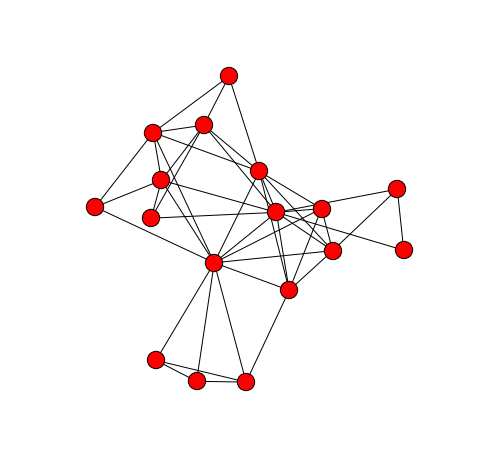

In [96]:
N = 3
V = range(N)
M = 10
E = set()
averageSize=3

#for j in xrange(M): 
#    n=min(max(1,np.random.poisson(averageSize)),N)
#    E.add(tuple(sorted(random.sample(V,n))))

K = 3 # dimension of hidden space
theta = np.random.lognormal(1,1,size=(K,N))
alpha=10.0
while 1:
    n=min(max(1,np.random.poisson(averageSize)),N)
    h=sorted(random.sample(V,n))
    p=ph(h,theta,alpha)
    if p>=0.5:#random.random()<=p:
        E.add(tuple(h))
    if len(E)>=M:
        break

G=nx.Graph()
G.add_edges_from(set([e for h in E for e in combinations(h,2)]))
plt.figure(figsize=(6,6)) 
nx.draw(G)

set([(0, 1, 2)])


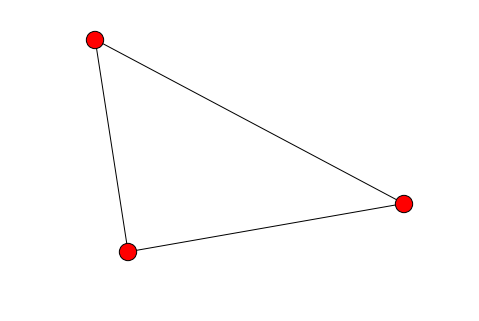

In [542]:
N = 3
V = range(N)
M = 1
E = set()
K = 3 # dimension of hidden space
theta = 1.65*np.array([[1,1,1],[1,1,1],[1,1,1]])
alpha=np.log(1.65)/2
for n in xrange(N):
    for h in combinations(V,n+1):
        if ph(h,theta,alpha)>0.5:
            E.add(h)

print E
G=nx.Graph()
G.add_edges_from(set([e for h in E for e in combinations(h,2)]))
nx.draw(G)

In [519]:
h=(0,1)
h2=(0,1,2)
ph(h,theta,alpha), theta[:,list(h)].prod(axis=1).sum()*np.exp(-len(h)*alpha),ph(h2,theta,alpha), theta[:,list(h2)].prod(axis=1).sum()*np.exp(-len(h2)*alpha)

(0.49748743718592964,
 4.9499999999999993,
 0.55979677187162624,
 6.3583901264392395)

In [520]:
def ph(h,theta,alpha):
    x=theta[:,list(h)].prod(axis=1).sum()*np.exp(-len(h)*alpha)
    return x/(5+x)
    
def sampleG(theta,alpha,E):
    change=dict()
    for i in xrange(10):
        n=np.random.poisson(averageSize)
        h=tuple(sorted(random.sample(V,min(max(n,1),N))))
        p=ph(h,theta,alpha)
        if random.random()<=p:
            if h not in E:
                change[h]=1
        else:
            if h in E:
                change[h]=0
    return change

#### Simulate $\theta$

In [521]:
K = 3 # dimension of hidden space
theta = np.random.lognormal(1+np.log(1.65),1,size=(K,N))
alpha=1.0
Y = dict()
aThetaRate=0.0
aAlphaRate=0.0
rOld=1
gamma=1

In [530]:
for i in xrange(5000):
    # Propose new theta
    thetaP = np.random.lognormal(1+np.log(1.65),1,size=(K,N))
    # Sample Y' from new theta
    YP=sampleG(thetaP,alpha,E)
    # Calculate transition probability
    r=1.0
    for h in YP:
        p=ph(h,thetaP,alpha)
        if YP[h]==0:
            if p==0:
                r=0
                break
            else:
                r*=p/(1-p)
        else:
            if p!=0:
                r*=(1-p)/p
    rho=r/rOld
    rho*=np.exp((-len(YP)+len(Y))/gamma)
    # Move
    if random.random()<rho:
        aThetaRate+=1
        theta=thetaP
        Y=YP
        rOld=r
    
    # Propose new alpha
    alphaP=abs(alpha+np.random.normal(scale=0.1))
    # Sample G' from new alpha
    YP=sampleG(thetaP,alpha,E)
    # Calculate transition probability
    r=1.0
    for h in YP:
        p=ph(h,theta,alphaP)
        if YP[h]==0:
            if p==0:
                r=0
                break
            else:
                r*=p/(1-p)
        else:
            if p!=0:
                r*=(1-p)/p
    rho=r/rOld
    rho*=np.exp((-len(YP)+len(Y))/gamma)
    rho*=norm.pdf(alphaP,np.log(1.65)/2,10)/norm.pdf(alpha,np.log(1.65)/2,10)
    # Move
    if random.random()<rho:
        aAlphaRate+=1
        alpha=alphaP
        Y=YP
        rOld=r

In [531]:
E, Y

({(0, 1, 2)}, {(0, 1, 2): 0})

In [532]:
theta,alpha,aThetaRate/5000,aAlphaRate/5000,rho

(array([[ 20.04592911,   5.24268983,   4.75563509],
        [  0.85032002,   3.58163325,   1.32754033],
        [  5.72202016,   6.58391147,   4.73630583]]),
 1.0719041331935437,
 0.3174,
 0.443,
 0.0026621575874313432)

In [533]:
E2=[]
for n in xrange(N):
    for h in combinations(V,n+1):
        print h,ph(h,theta,alpha)

(0,) 0.645714815619
(1,) 0.513386807974
(2,) 0.425559018932
(0, 1) 0.773657779247
(0, 2) 0.743356993221
(1, 2) 0.587951278657
(0, 1, 2) 0.845570043679


In [ ]:
L=[]
samples=[]
LRandom=[]
randomSamples=[]
for e in E:
    if len(e)<2:
        continue
    samples.append(e)
    L.append(poisson.pmf(E[e],Lambda(e,theta,alpha)))
    while True:
        n=len(e)#np.random.poisson(len(e))
        e0=tuple(sorted(random.sample(V,min(max(n,1),N)),reverse=True))
        if e0 not in E0:
            break
    randomSamples.append(e0)
    LRandom.append(poisson.pmf(1,Lambda(e0,theta,alpha)))

plt.hist([L,LRandom])

In [ ]:
max(L),max(LRandom)

In [ ]:
zip(randomSamples,samples)

In [ ]:
Lambda((14544, 11249, 9499),theta,alpha), Lambda( (11763, 2528, 1879),theta,alpha)

In [ ]:
theta[:,list((14544, 11249, 9499))],theta[:,list( (11763, 2528, 1879))]